<a href="https://colab.research.google.com/github/pati-dev/predict-shopping-intention/blob/master/predict_purchase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boot

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Load Data

In [0]:
shop = pd.read_csv("/content/drive/My Drive/Personal/IUB/Job apps/Capgemini/online_shoppers_intention.csv")

In [4]:
shop.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Data preprocessing

In [5]:
print(shop.columns)
print(shop.dtypes)

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object


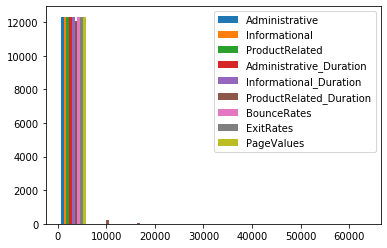

In [8]:
pages = ['Administrative',
         'Informational',
         'ProductRelated',
         'Administrative_Duration',
         'Informational_Duration',
         'ProductRelated_Duration',
         'BounceRates',
         'ExitRates',
         'PageValues']

x_pages = shop.loc[:, pages].values

plt.hist(x_pages, label=pages)
plt.legend()
plt.show()

### Feature scaling

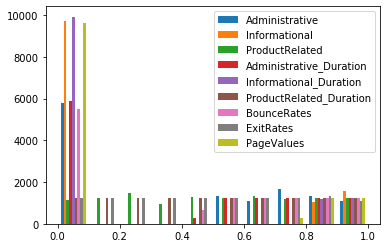

In [9]:
x_pages = QuantileTransformer(output_distribution='uniform').fit_transform(x_pages)
plt.hist(x_pages, label=pages)
plt.legend()
plt.show()

### Dimension reduction

% variance explained: 98.07948987307485


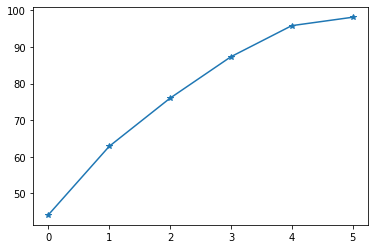

In [10]:
pca = PCA(n_components=6)

pca.fit(x_pages)

print("% variance explained:", sum(pca.explained_variance_ratio_)*100)
variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(variance, marker='*')
plt.show()

# Data preparation

In [0]:
pages_pca = pca.fit_transform(x_pages)

df_pages_pca = pd.DataFrame(data = pages_pca,
                            columns = ['pages_pc1',
                                       'pages_pc2',
                                       'pages_pc3',
                                       'pages_pc4',
                                       'pages_pc5',
                                       'pages_pc6'])

shop['is_weekend'] = np.where(shop['Weekend']==True, 1, 0)
shop['returning_visitor'] = np.where(shop['VisitorType']=="Returning_Visitor", 1, 0)
shop['purchase'] = np.where(shop['Revenue']==True, 1, 0)

cols = ['is_weekend',
        'returning_visitor',
        'SpecialDay',
        'purchase']
df_shop = shop.loc[:, cols]

# Generate data, fit model, and evaluate

In [0]:
def generate_data(df_pca, df_raw, labels):
  pca_cols, raw_cols = df_pca.columns, df_raw.columns
  # Remove labels from features
  raw_cols = raw_cols[ raw_cols != labels ]

  # Prepare combinations of raw features
  raw_combos = []
  for i in range(1, len(raw_cols)+1):
    for combo in itertools.combinations(raw_cols, i):
      raw_combos += [list(combo)]
  
  for pca_idx in range( len(pca_cols), 0, -1):
    for raw_combo in raw_combos:
      pca_combo = pca_cols[:pca_idx]
      
      x = pd.concat( [df_pca.loc[:, pca_combo], df_raw.loc[:, raw_combo]], axis=1 )
      y = df_raw[labels]

      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

      yield x_train, x_test, y_train, y_test

In [0]:
def fit_log_reg(x_train, y_train):
  lr_model = LogisticRegression()

  # solver = ['lbfgs', 'newton-cg']
  # C = np.logspace(0, 4, 10)
  solver = ['lbfgs']
  C = [1]

  hyperparams = dict(solver=solver, C=C)

  # 5-fold cross-validation
  clf = GridSearchCV(lr_model, hyperparams, cv=5)
  model = clf.fit(x_train, y_train)

  return model

In [0]:
def evaluate(model, x_test, y_test, results):
  predictions = model.predict(x_test)

  C = metrics.confusion_matrix(y_test, predictions)

  n_samples = len(y_test)
  tn, fp, fn, tp = C[0][0], C[0][1], C[1][0], C[1][1]
  
  precision = tp / (tp + fp) * 100
  recall = tp / (tp + fn) * 100
  accuracy = (tp + tn) / (tp + fp + tn + fn) * 100

  print("\n\nResults for model with features:", x_test.columns.values)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)

  # Populate results in dict
  results[tuple(x_test.columns)] = {"accuracy" : accuracy,
                                    "precision" : precision,
                                    "recall" : recall}
  
  return None

In [84]:
train_results = {}
test_results = {}

for x_train, x_test, y_train, y_test in generate_data(df_pca=df_pages_pca, df_raw=df_shop, labels='purchase'):
  model = fit_log_reg(x_train=x_train, y_train=y_train)
  evaluate(model=model, x_test=x_train, y_test=y_train, results=train_results)
  evaluate(model=model, x_test=x_test, y_test=y_test, results=test_results)



Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend']
Accuracy: 90.02433090024331
Precision: 68.65671641791045
Recall: 60.80870917573873


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend']
Accuracy: 88.83482022168153
Precision: 70.2127659574468
Recall: 58.36012861736335


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'returning_visitor']
Accuracy: 90.14019232997336
Precision: 70.19498607242339
Recall: 58.78693623639192


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'returning_visitor']
Accuracy: 88.48337388483374
Precision: 70.08196721311475
Recall: 54.983922829581985


Results for model with features: ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'SpecialDay']
Accuracy: 89.85053875564824
Precision: 

# Copy paste results in Excel

In [94]:
for features, met in train_results.items():
  # print(features)
  # print(met['accuracy'])
  # print(met['precision'])
  print(met['recall'])

60.80870917573873
58.78693623639192
61.353032659409024
58.55365474339036
60.73094867807154
58.70917573872473
58.70917573872473
59.95334370139969
58.320373250388805
60.65318818040435
58.47589424572317
60.26438569206844
58.39813374805599
58.24261275272161
43.07931570762053
43.856920684292376
42.92379471228615
43.701399688958006
42.76827371695179
43.77916018662519
43.856920684292376
6.298600311041991
6.6874027993779155
6.60964230171073
7.076205287713841
6.298600311041991
6.920684292379471
7.076205287713841
3.8880248833592534
5.05443234836703
3.7325038880248838
5.132192846034215
3.9657853810264383
5.209953343701399
5.05443234836703
1.9440124416796267
2.177293934681182
2.021772939346812
2.2550544323483668
2.021772939346812
2.332814930015552
2.2550544323483668


In [91]:
for features, met in test_results.items():
  # print(features)
  # print(met['accuracy'])
  # print(met['precision'])
  print(met['recall'])

58.36012861736335
54.983922829581985
58.36012861736335
54.983922829581985
58.68167202572347
55.30546623794213
55.78778135048231
56.91318327974276
55.30546623794213
56.91318327974276
55.78778135048231
56.59163987138264
56.27009646302251
55.78778135048231
40.353697749196144
40.51446945337621
41.80064308681672
40.836012861736336
41.639871382636656
42.443729903536976
41.961414790996784
5.305466237942122
5.305466237942122
4.983922829581994
5.305466237942122
5.144694533762058
5.305466237942122
5.144694533762058
1.7684887459807075
3.536977491961415
2.2508038585209005
2.8938906752411575
2.090032154340836
3.376205787781351
2.8938906752411575
0.964630225080386
1.7684887459807075
1.7684887459807075
1.7684887459807075
1.4469453376205788
1.7684887459807075
1.7684887459807075
